### Structural Estimation Q3
First we once again load some required packages and read in our data.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
%matplotlib inline

In [3]:
usi =  pd.read_csv("usincmoms.txt", sep='\t', header = None, names = ['m','midpt'])

#### (a)
Let us plot a histogram of all 42 bins.

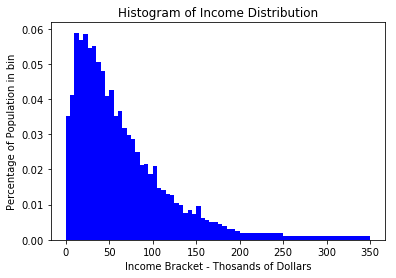

In [37]:
freq = np.copy(usi['m'])
freq[41] = freq[41]/20
freq[40] = freq[40]/10

fig, ax = plt.subplots()
rect1 = ax.bar(usi['midpt'][:40]/1000, freq[:40],width =5 ,color='b')
rect2 = ax.bar(usi['midpt'][40]/1000, freq[40],width = 5*10, color='b' )
rect3 = ax.bar(usi['midpt'][41]/1000, freq[41], width = 5*20, color='b')
plt.ylabel("Percentage of Population in bin")
plt.xlabel("Income Bracket - Thosands of Dollars")
plt.title("Histogram of Income Distribution")
plt.show()

#### (b)

We will now proceed to estimate the parameters of the income distribution assuming a log-normal distribution by matching the 42 moments in the data. We first do this with a weighting matrix of the moments in the data.

In [5]:
def lognorm(x, mu, sigma):
    val = sts.norm.cdf(np.log(x), mu, sigma)
    return val

def model_moments(mu, sigma,midpts):
    mom = np.zeros(42)
    mom[0] = lognorm(midpts[0]+2500, mu, sigma)
    for i in range(1,40):
        mom[i] = (lognorm(midpts[i]+2500, mu, sigma) -
                  lognorm(midpts[i-1] + 2500, mu, sigma))
    mom[40] = (lognorm(midpts[40]+25000, mu, sigma) -
                  lognorm(midpts[39] + 25000, mu, sigma))
    mom[41] = 1 - lognorm(midpts[40]+25000, mu, sigma)
    return mom

def err_vec(mu, sigma, midpts, m):
    err_vec = abs(model_moments(mu, sigma, midpts) - m)/ m
    return err_vec

def crit(params, *args):
    mu, sigma = params
    midpts, m , W = args
    err = err_vec(mu, sigma, midpts, m)
    crit_val = np.dot(np.dot(err.T, W),err)
    return crit_val

In [43]:
params1 = (np.log(usi['m'].dot(usi['midpt'])), 100)
args1 = (usi['midpt'], usi['m'], np.diag(usi['m']))

results1 = opt.minimize(crit, params1, args1, method ='Nelder-Mead', tol = 1e-8)
gmmlognorm_mu, gmmlognorm_sigma = results1.x[0], results1.x[1]
print("GMM Estimate of Mu = ", gmmlognorm_mu, "\nGMM Estimate of Sigma = ", gmmlognorm_sigma, 
     "\nCriterion Function Value = ", results1.fun)

GMM Estimate of Mu =  10.7786519105 
GMM Estimate of Sigma =  0.913991049981 
Criterion Function Value =  0.0483366188409


We can investigate if these values are susceptible to various starting points.

In [44]:
params12 = (20, 10)
params13 = (5, 15)
args1 = (usi['midpt'], usi['m'], np.diag(usi['m']))

results12 = opt.minimize(crit, params12, args1, method ='Nelder-Mead', tol = 1e-8)
results13 = opt.minimize(crit, params13, args1, method ='Nelder-Mead', tol = 1e-8)
gmmlognorm_mu12, gmmlognorm_sigma12 = results12.x[0], results12.x[1]
gmmlognorm_mu13, gmmlognorm_sigma13 = results13.x[0], results13.x[1]
print("GMM Estimate of Mu = ", gmmlognorm_mu12, "\nGMM Estimate of Sigma = ", gmmlognorm_sigma12, 
     "\nGMM Estimate of Mu = ", gmmlognorm_mu13, "\nGMM Estimate of Sigma = ", gmmlognorm_sigma13)

GMM Estimate of Mu =  10.7786519158 
GMM Estimate of Sigma =  0.91399105872 
GMM Estimate of Mu =  10.7786519117 
GMM Estimate of Sigma =  0.913991060287


As we can see, the values for $\mu$ and $\sigma$ do not change even with different initial parameter guesses.

With these values, we can then plot a graph of the distribution predicted by the GMM Estimator over the original histogram of model moments.

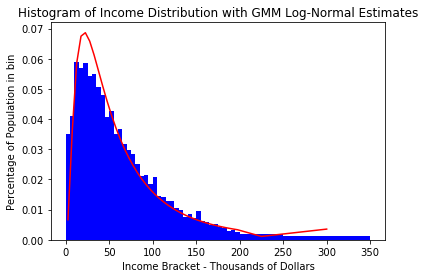

In [36]:
freq = np.copy(usi['m'])
freq[41] = freq[41]/20
freq[40] = freq[40]/10

gmm_lognorm_fitted = model_moments(gmmlognorm_mu, gmmlognorm_sigma, usi['midpt'])
gmm_lognorm_fitted[40] = gmm_lognorm_fitted[40]/10
gmm_lognorm_fitted[41] = gmm_lognorm_fitted[41]/10

fig, ax = plt.subplots()
plt.plot(usi['midpt']/1000, gmm_lognorm_fitted, color="r")
rect1 = ax.bar(usi['midpt'][:40]/1000, freq[:40],width =5 ,color='b')
rect2 = ax.bar(usi['midpt'][40]/1000, freq[40],width = 5*10, color='b' )
rect3 = ax.bar(usi['midpt'][41]/1000, freq[41], width = 5*20, color='b')
plt.ylabel("Percentage of Population in bin")
plt.xlabel("Income Bracket - Thousands of Dollars")
plt.title("Histogram of Income Distribution with GMM Log-Normal Estimates")
plt.show()

#### (c)

We can also try to fit the moments in the data to a gamma distribution using MLE.

In [9]:
from scipy.special import gamma

def gammacdf(x ,a, b):
    pdf = lambda x:  1/((b**a)* gamma(a)) *(x ** (a - 1))* np.exp(-x/b)
    return intgr.quad(pdf, 0, x)[0]

def model_moments_gm(a,b,midpts):
    mom = np.zeros(42)
    mom[0] = gammacdf(midpts[0]+2500,a,b)
    for i in range(1,40):
        mom[i] = (gammacdf(midpts[i]+2500, a,b) -
                  gammacdf(midpts[i-1] + 2500, a,b))
    mom[40] = (gammacdf(midpts[40]+25000, a,b) -
                  gammacdf(midpts[39] + 25000, a,b))
    mom[41] = 1 - gammacdf(midpts[40]+25000, a,b)
    return mom

def err_vec_gm(a,b,midpts, m):
    err_vec = abs(model_moments_gm(a, b, midpts) - m)/ m
    return err_vec

def crit2(params, *args):
    a, b = params
    midpts, m , W = args
    err = err_vec_gm(a,b, midpts, m)
    crit_val = np.dot(np.dot(err.T, W),err)
    return crit_val

In [10]:
paramsgm = (3, 20000)
args = (usi['midpt'], usi['m'], np.diag(usi['m']))

results2 = opt.minimize(crit2, paramsgm, args, method='Nelder-Mead')

gmmgm_alpha, gmmgm_beta = results2.x[0], results2.x[1]
print("GMM Estimate of Alpha = ", gmmgm_alpha, "\nGMM Estimate of Beta = ", gmmgm_beta, 
     "\nCriterion Function Value = ", results2.fun)

GMM Estimate of Alpha =  1.33062334786 
GMM Estimate of Beta =  50776.458894 
Criterion Function Value =  0.0171949079182


With these values, we can then plot a graph of the distribution predicted by the GMM Estimator over the original histogram of model moments.

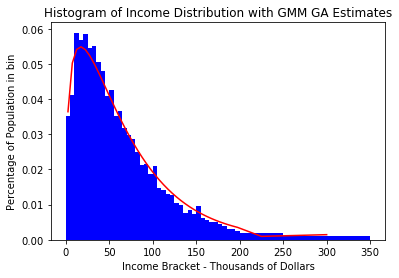

In [35]:
freq = np.copy(usi['m'])
freq[41] = freq[41]/20
freq[40] = freq[40]/10

gmm_gm_fitted = model_moments_gm(gmmgm_alpha, gmmgm_beta, usi['midpt'])
gmm_gm_fitted[40] = gmm_gm_fitted[40]/10
gmm_gm_fitted[41] = gmm_gm_fitted[41]/10

fig, ax = plt.subplots()
plt.plot(usi['midpt']/1000, gmm_gm_fitted, color="r")
rect1 = ax.bar(usi['midpt'][:40]/1000, freq[:40],width =5 ,color='b')
rect2 = ax.bar(usi['midpt'][40]/1000, freq[40],width = 5*10, color='b' )
rect3 = ax.bar(usi['midpt'][41]/1000, freq[41], width = 5*20, color='b')
plt.ylabel("Percentage of Population in bin")
plt.xlabel("Income Bracket - Thousands of Dollars")
plt.title("Histogram of Income Distribution with GMM GA Estimates")
plt.show()

#### (d)
We can overlay the two plots in order to compare their fit. In addition, we can also consider the goodness of fit by looking at the minimizer of the criterion function, since this corresponds to how well our final parameters under each distribution match the list of model moments. Note that this comparison here works since we use the same weighting matrix from before, and therefore is an easier way to compare the errors.

From the graphs, it appears that the Gamma Distribution seems to match the data much better than the Log-Normal one. This is also true when considering the value of the criterion function.

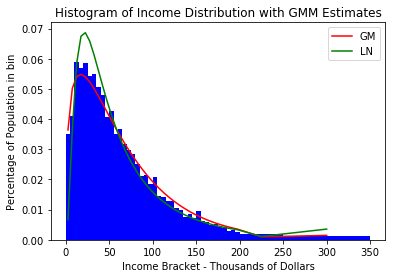

In [34]:
fig, ax = plt.subplots()
plt.plot(usi['midpt']/1000, gmm_gm_fitted, color="r", label="GM")
plt.plot(usi['midpt']/1000, gmm_lognorm_fitted, color="g", label="LN")
rect1 = ax.bar(usi['midpt'][:40]/1000, freq[:40],width =5 ,color='b')
rect2 = ax.bar(usi['midpt'][40]/1000, freq[40],width = 5*10, color='b' )
rect3 = ax.bar(usi['midpt'][41]/1000, freq[41], width = 5*20, color='b')
plt.ylabel("Percentage of Population in bin")
plt.xlabel("Income Bracket - Thousands of Dollars")
plt.title("Histogram of Income Distribution with GMM Estimates")
plt.legend()
plt.show()

#### (e)
We can now attempt to run a two step estimation procedure for the Gamma Distribution.

In [23]:
#Generate New Weighting Matrix
err1 = err_vec_gm(gmmgm_alpha, gmmgm_beta, usi['midpt'], usi['m'])
VCV = np.outer(err1, err1) / usi['midpt'].shape[0]
W2 = np.linalg.pinv(VCV)

#Initialize Parameters
paramsgm2 = (gmmgm_alpha, gmmgm_beta)
args2 = (usi['midpt'], usi['m'], W2)

results22 = opt.minimize(crit2, paramsgm2, args2, method='Nelder-Mead')

gmmgm_alpha2, gmmgm_beta2 = results22.x[0], results22.x[1]
print("2 Step GMM Estimate of Alpha = ", gmmgm_alpha2, "\n2 Step GMM Estimate of Beta = ", gmmgm_beta2, 
     "\n2 Step Criterion Function Value = ", results22.fun)

2 Step GMM Estimate of Alpha =  1.34573730773 
2 Step GMM Estimate of Beta =  46156.4867502 
2 Step Criterion Function Value =  20.6064876126


In order to compare this result with the 1 step estimate done in part (c), we would need to look at the distribution generated by this new weighting. Note here that we can no longer compare the criterion function value since we are using a new weighting matrix.

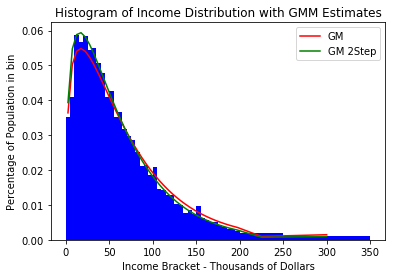

In [38]:
fig, ax = plt.subplots()

gmm_gm_fitted2 = model_moments_gm(gmmgm_alpha2, gmmgm_beta2, usi['midpt'])
gmm_gm_fitted2[40] = gmm_gm_fitted2[40]/10
gmm_gm_fitted2[41] = gmm_gm_fitted2[41]/10

plt.plot(usi['midpt']/1000, gmm_gm_fitted, color="r", label="GM")
plt.plot(usi['midpt']/1000, gmm_gm_fitted2, color="g", label="GM 2Step")
rect1 = ax.bar(usi['midpt'][:40]/1000, freq[:40],width =5 ,color='b')
rect2 = ax.bar(usi['midpt'][40]/1000, freq[40],width = 5*10, color='b' )
rect3 = ax.bar(usi['midpt'][41]/1000, freq[41], width = 5*20, color='b')
plt.ylabel("Percentage of Population in bin")
plt.xlabel("Income Bracket - Thousands of Dollars")
plt.title("Histogram of Income Distribution with GMM Estimates")
plt.legend()
plt.show()

We do get a better fit for the overall distribution from using the 2 step estimation to obtain parameters for our gamma distribution.